In [0]:
%pip install tensorflow

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [0]:
import requests
from datetime import datetime, timedelta

In [0]:
df = pd.read_csv('Data/seattle-weather.csv')

In [0]:
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [0]:
df.isnull().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [0]:
data = df[['temp_max']].values 

In [0]:
scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data) 

In [0]:
def create_dataset(dataset, window_size=10):
    X, y = [], []

    for i in range(window_size, len(dataset)):
        X.append(dataset[i-window_size:i, 0])
        y.append(dataset[i,0])

    return np.array(X), np.array(y)

WINDOW_SIZE = 10
X, y = create_dataset(data_scaled, WINDOW_SIZE)

In [0]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [0]:
X_train.shape

(1160, 10)

In [0]:
X_test.shape

(291, 10)

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [0]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(WINDOW_SIZE, 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

/local_disk0/.ephemeral_nfs/envs/pythonEnv-7cacef00-58bb-4261-b53a-9d1a7488a4cc/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [0]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.1100 - val_loss: 0.0079
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0159 - val_loss: 0.0085
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0141 - val_loss: 0.0080
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0126 - val_loss: 0.0080
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0135 - val_loss: 0.0079
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0115 - val_loss: 0.0081
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0130 - val_loss: 0.0083
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0115 - val_loss: 0.0086
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0129 - val_loss: 0.0076
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0125 - val_loss: 0.0078
Epoch 11/50
 3/33 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0122

*** WARNING: max output size exceed

In [0]:
predictions = model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


In [0]:
predictions = scaler.inverse_transform(predictions.reshape(-1,1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

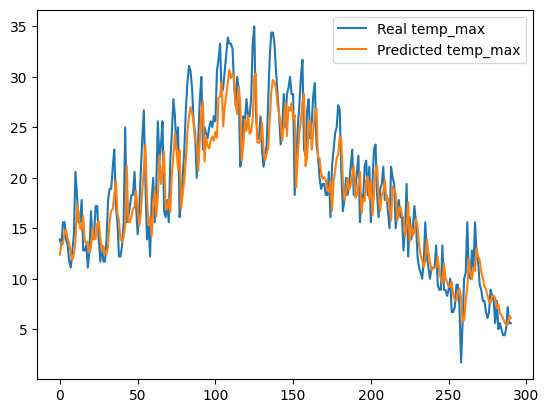

In [0]:
plt.plot(y_test_actual, label='Real temp_max')
plt.plot(predictions, label='Predicted temp_max')
plt.legend()
plt.show()

#Prevision of today weather in Madrid

In [0]:
#Madrid
latitude = 40.4168
longitude = -3.7038

end_date = datetime.today()
start_date = end_date - timedelta(days=10)

start = start_date.strftime("%Y-%m-%d")
end = end_date.strftime("%Y-%m-%d")

url = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start}&end_date={end}&daily=temperature_2m_max&timezone=Europe%2FMadrid"
response = requests.get(url)
data = response.json()

temps = data['daily']['temperature_2m_max']
dates = data['daily']['time']

df = pd.DataFrame({'date': dates, 'temp_max': temps})
print(df)

          date  temp_max
0   2025-06-30      36.4
1   2025-07-01      36.9
2   2025-07-02      37.3
3   2025-07-03      36.9
4   2025-07-04      36.5
5   2025-07-05      34.8
6   2025-07-06      34.8
7   2025-07-07      35.7
8   2025-07-08      34.6
9   2025-07-09      30.1
10  2025-07-10       NaN


In [0]:
scaler = MinMaxScaler()
scaler.fit(df[['temp_max']])
temp_scaled = scaler.transform(df[['temp_max']])
temp_scaled = temp_scaled[~np.isnan(temp_scaled).flatten()]

In [0]:
print(temp_scaled)

[[0.875     ]
 [0.94444444]
 [1.        ]
 [0.94444444]
 [0.88888889]
 [0.65277778]
 [0.65277778]
 [0.77777778]
 [0.625     ]
 [0.        ]]


In [0]:
X_input = temp_scaled.reshape(1, 10, 1)

In [0]:
# Previsão
y_pred_scaled = model.predict(X_input)

# Inverso da normalização
y_pred = scaler.inverse_transform(y_pred_scaled)

print("Maximum temperature forecast for today:", y_pred[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Maximum temperature forecast for today: 32.324448
